# Deep Learning - LSTM

In this section, LSTM is used to forecast the apple prices.

## ⚠️ Disclaimer

> This project is created **for educational and research purposes only**.  
> It does **not** constitute investment advice, financial recommendations, or a solicitation to buy or sell any securities.
>
> All data is sourced from [Yahoo Finance](https://finance.yahoo.com/) using the `yfinance` Python package.  
> This project is **not affiliated with, endorsed by, officially connected to Apple Inc.** or Yahoo Finance in any way. in any way.

In [1]:
#Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
apple_df = yf.Ticker("AAPL").history(
    start="2020-03-30",
    end="2025-03-29",
    interval="1d"
)
apple_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-30 00:00:00-04:00,60.849342,62.009348,60.524149,61.837044,167976400,0.0,0.0
2020-03-31 00:00:00-04:00,62.028766,63.700821,61.155120,61.710854,197002000,0.0,0.0
2020-04-01 00:00:00-04:00,59.820369,60.359117,58.031826,58.463795,176218400,0.0,0.0
2020-04-02 00:00:00-04:00,58.325477,59.492763,57.490661,59.439373,165934000,0.0,0.0
2020-04-03 00:00:00-04:00,58.922464,59.626232,57.993003,58.585140,129880000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,221.000000,221.479996,218.580002,220.729996,44299500,0.0,0.0
2025-03-25 00:00:00-04:00,220.770004,224.100006,220.080002,223.750000,34493600,0.0,0.0
2025-03-26 00:00:00-04:00,223.509995,225.020004,220.470001,221.529999,34466100,0.0,0.0


In [3]:
#Dividing date to year, month and day columns, and resetting index
apple_df.index = pd.to_datetime(apple_df.index)
apple_df["Day_of_Week"] = apple_df.index.dayofweek
apple_df["Year"] = apple_df.index.year
apple_df["Month"] = apple_df.index.month
apple_df["Day"] = apple_df.index.day
apple_df = apple_df.reset_index(drop=True)
#Creating lags for Close price
for lag in range(1, 62):
    apple_df[f"Close_lag_{lag}"] = apple_df["Close"].shift(lag)
#Getting to moving averages of previous days
apple_df["Previous_MA_5"] = apple_df["Close"].rolling(window=5).mean()
apple_df["Previous_MA_20"] = apple_df["Close"].rolling(window=20).mean()
apple_df["Previous_MA_ratio"] = apple_df["Previous_MA_5"] / apple_df["Previous_MA_20"]
apple_df.drop(columns=["Dividends","Stock Splits"],inplace=True)
apple_df.dropna(inplace=True)

## Functions

In [4]:
def create_sequences(data: np.ndarray, seq_length: int):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [5]:
def train_val_test_split(X: np.ndarray, y: np.ndarray,
                         train_ratio: float = 0.8,
                         val_ratio: float = 0.10):

    total = len(X)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
def prepare_rnn_data(df: pd.DataFrame,
                     target_col: str = 'Close',
                     use_all_features: bool = False,
                     seq_length: int = 60):

    y_values = df[target_col].values

    if use_all_features:
        X_raw = df.values
    else:
        X_raw = df[[target_col]].values

    X_seq, y_seq = create_sequences(X_raw, seq_length)
    y_seq = y_values[seq_length:]

    return train_val_test_split(X_seq, y_seq)

In [60]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_rnn_data(
    apple_df,
    target_col='Close',
    use_all_features=False,
    seq_length=60
)

In [63]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = x_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = x_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = x_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [62]:
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

# LSTM Models, Only Close Feature

In [64]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
model_LSTM_1 = Sequential(
    [
        LSTM(units=64, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        Dropout(0.2),
        LSTM(units=32),
        Dropout(0.2),
        Dense(1)
    ]
)

model_LSTM_1.compile(optimizer='adam', loss='mse', metrics=['mse'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
history = model_LSTM_1.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

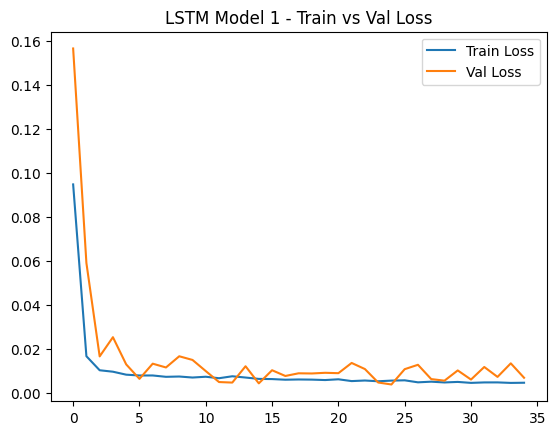

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model 1 - Train vs Val Loss')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
y_pred = y_scaler.inverse_transform(model_LSTM_1.predict(X_test_scaled))
y_test_orig = y_scaler.inverse_transform(y_test_scaled)
r2= r2_score(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mape = mean_absolute_percentage_error(y_test_orig, y_pred)
print(f"R^2 is {r2} \n RMSE is {rmse} \n MAPE is {mape}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
R^2 is 0.5223005081556669 
 RMSE is 7.437890653998657 
 MAPE is 0.025786569127697976


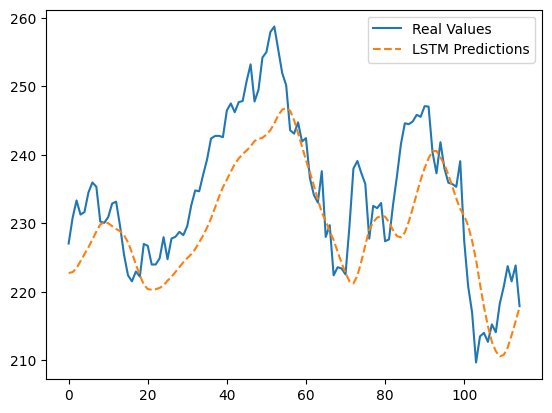

In [16]:
plt.plot(y_test_orig, label='Real Values')
plt.plot(y_pred, label='LSTM Predictions', linestyle='--')
plt.legend()
plt.show()

In [65]:
from tensorflow.keras import regularizers

model_advanced_lstm_l2 = Sequential([
    LSTM(
        128,
        return_sequences=True,
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
        kernel_regularizer=regularizers.l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(
        64,
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(
        32,
        kernel_regularizer=regularizers.l2(0.001)
    ),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1)
])

model_advanced_lstm_l2.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
history = model_advanced_lstm_l2.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

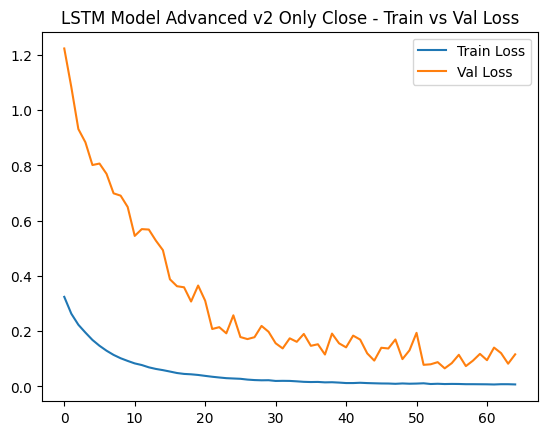

In [67]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Advanced v2 Only Close - Train vs Val Loss')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
y_pred = y_scaler.inverse_transform(model_advanced_lstm_l2.predict(X_test_scaled))
y_test_orig = y_scaler.inverse_transform(y_test_scaled)
r2= r2_score(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mape = mean_absolute_percentage_error(y_test_orig, y_pred)
print(f"R^2 is {r2} \n RMSE is {rmse} \n MAPE is {mape}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
R^2 is -10.006248751948148 
 RMSE is 35.70196022367239 
 MAPE is 0.1455769519538776


# LSTM all features

In [24]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_rnn_data(
    apple_df,
    target_col='Close',
    use_all_features=True,
    seq_length=60
)

In [25]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = x_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = x_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = x_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [26]:
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

In [29]:
model_LSTM_1 = Sequential(
    [
        LSTM(units=64, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        Dropout(0.2),
        LSTM(units=32),
        Dropout(0.2),
        Dense(1)
    ]
)

model_LSTM_1.compile(optimizer='adam', loss='mse', metrics=['mse'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
history = model_LSTM_1.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

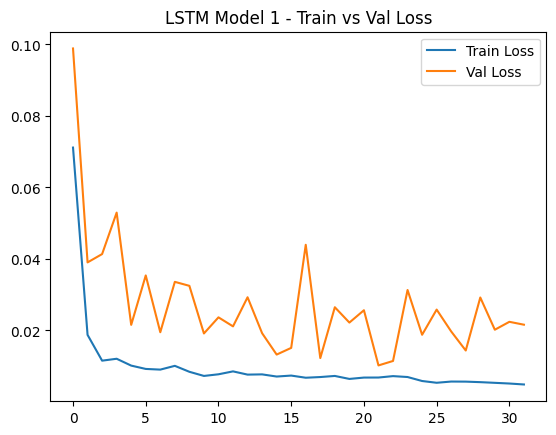

In [31]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model 1 - Train vs Val Loss')
plt.legend()
plt.show()

In [32]:
y_pred = y_scaler.inverse_transform(model_LSTM_1.predict(X_test_scaled))
y_test_orig = y_scaler.inverse_transform(y_test_scaled)
r2= r2_score(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mape = mean_absolute_percentage_error(y_test_orig, y_pred)
print(f"R^2 is {r2} \n RMSE is {rmse} \n MAPE is {mape}")

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
R^2 is -2.003341741442755 
 RMSE is 18.64982563732242 
 MAPE is 0.07170073902284342


In [33]:
model_LSTM_2 = Sequential(
    [
        LSTM(units=128, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        Dropout(0.2),
        LSTM(units=32),
        Dropout(0.2),
        Dense(1)
    ]
)

model_LSTM_2.compile(optimizer='adam', loss='mse', metrics=['mse'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
history = model_LSTM_2.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

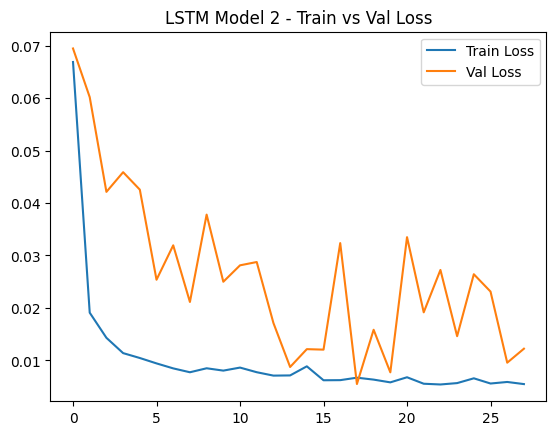

In [35]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model 2 - Train vs Val Loss')
plt.legend()
plt.show()

In [36]:
y_pred = y_scaler.inverse_transform(model_LSTM_2.predict(X_test_scaled))
y_test_orig = y_scaler.inverse_transform(y_test_scaled)
r2= r2_score(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mape = mean_absolute_percentage_error(y_test_orig, y_pred)
print(f"R^2 is {r2} \n RMSE is {rmse} \n MAPE is {mape}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
R^2 is -0.7837908608386361 
 RMSE is 14.372898777189231 
 MAPE is 0.052227710850847285


In [37]:
from tensorflow.keras.layers import BatchNormalization

In [38]:
model_advanced_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model_advanced_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [40]:
history = model_advanced_lstm.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

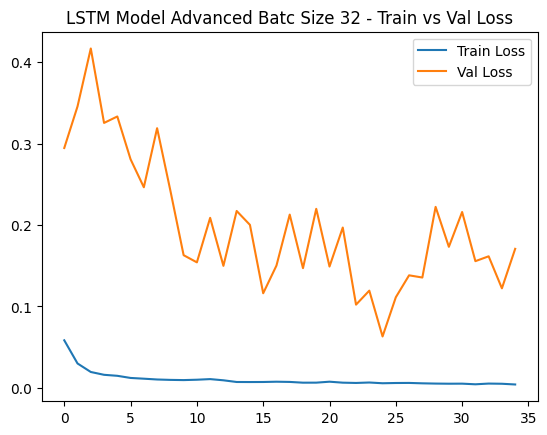

In [41]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Advanced Batc Size 32 - Train vs Val Loss')
plt.legend()
plt.show()

In [43]:
history = model_advanced_lstm.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=0
)

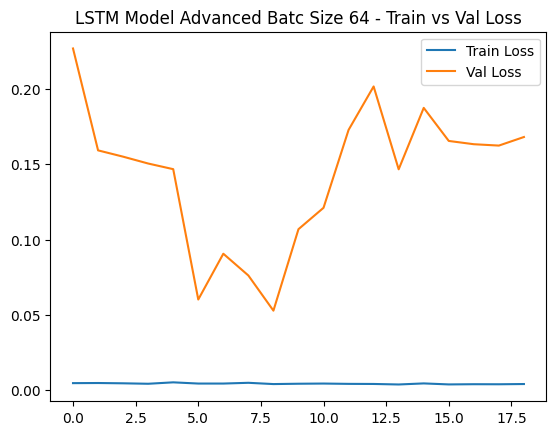

In [44]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Advanced Batc Size 64 - Train vs Val Loss')
plt.legend()
plt.show()

In [46]:
history = model_advanced_lstm.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=0
)

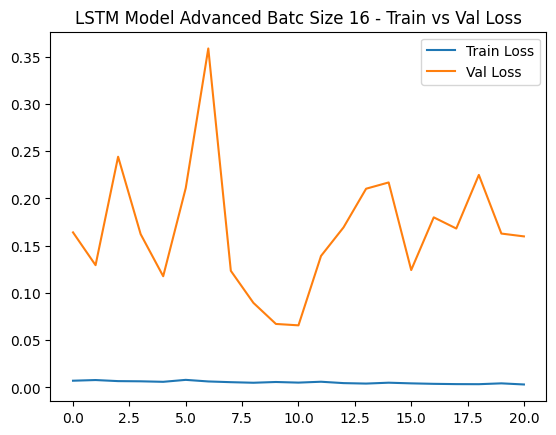

In [47]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Advanced Batc Size 16 - Train vs Val Loss')
plt.legend()
plt.show()

In [55]:
y_pred = y_scaler.inverse_transform(model_advanced_lstm.predict(X_test_scaled))
y_test_orig = y_scaler.inverse_transform(y_test_scaled)
r2= r2_score(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mape = mean_absolute_percentage_error(y_test_orig, y_pred)
print(f"R^2 is {r2} \n RMSE is {rmse} \n MAPE is {mape}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
R^2 is -15.558147915178804 
 RMSE is 43.79033611901227 
 MAPE is 0.18036500502682276


In [49]:
history = model_advanced_lstm.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=0
)

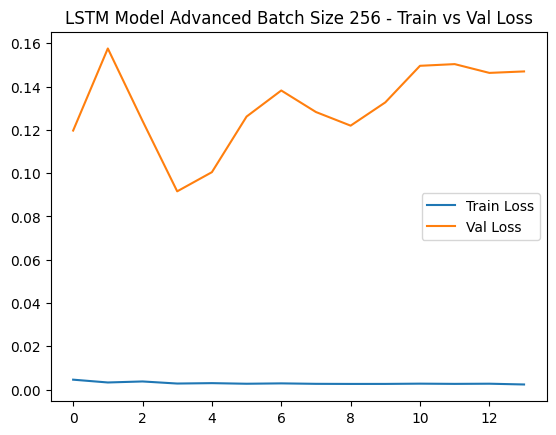

In [51]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Advanced Batch Size 256 - Train vs Val Loss')
plt.legend()
plt.show()

In [52]:


model_advanced_lstm_l2 = Sequential([
    LSTM(
        128,
        return_sequences=True,
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
        kernel_regularizer=regularizers.l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(
        64,
        return_sequences=True,
        kernel_regularizer=regularizers.l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(
        32,
        kernel_regularizer=regularizers.l2(0.001)
    ),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1)
])

model_advanced_lstm_l2.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
history = model_advanced_lstm_l2.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

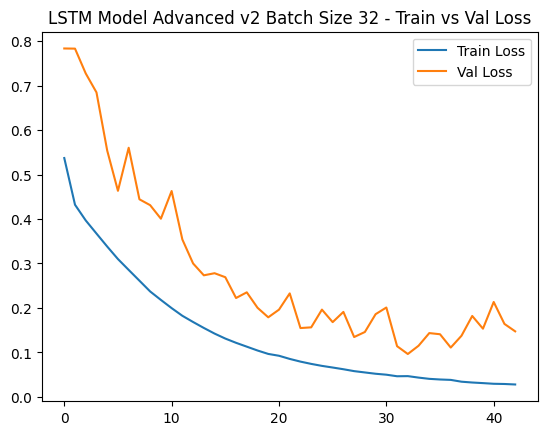

In [54]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Advanced v2 Batch Size 32 - Train vs Val Loss')
plt.legend()
plt.show()

In [56]:
y_pred = y_scaler.inverse_transform(model_advanced_lstm_l2.predict(X_test_scaled))
y_test_orig = y_scaler.inverse_transform(y_test_scaled)
r2= r2_score(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mape = mean_absolute_percentage_error(y_test_orig, y_pred)
print(f"R^2 is {r2} \n RMSE is {rmse} \n MAPE is {mape}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
R^2 is -12.655865763167753 
 RMSE is 39.767841507354234 
 MAPE is 0.1628941468677572


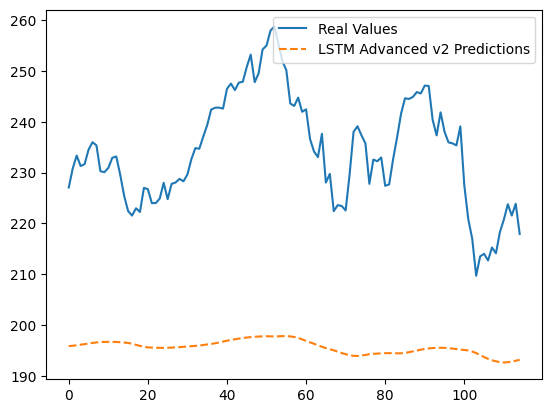

In [59]:
plt.plot(y_test_orig, label='Real Values')
plt.plot(y_pred, label='LSTM Advanced v2 Predictions', linestyle='--')
plt.legend()
plt.show()